# Inference a real model

How to inference a real model trainned by another framework like tensorflow/pytorch/PDPD?

Assume the model is supported by OpenVINO, here is the process of running inference using 
This is little complex in OpenVINO, offline conversion(model optimizer)

## Download onnx model

```bash
wget https://media.githubusercontent.com/media/onnx/models/main/vision/classification/resnet/model/resnet18-v1-7.tar.gz
tar -xf resnet18-v1-7.tar.gz
```

## Read the model

In [1]:
from openvino.preprocess import PrePostProcessor
import openvino.runtime as ov
import numpy as np
import time
from pandas import DataFrame
from graphviz import Digraph, Source
import ovhelper

# this is top object
core = ov.Core()

model = core.read_model("./resnet18-v1-7/resnet18-v1-7.onnx")

ovhelper.print_model(model)

model(Parameter_102):
    Tensor<1x3x224x224xf32> t1 = Parameter(element_type=f32)    # data
    Tensor<64x3x7x7xf32> t2 = Constant(element_type=f32,shape=[64, 3, 7, 7])    # resnetv15_conv0_weight
    Tensor<1x64x112x112xf32> t3 = Convolution(t1,t2,strides=[2, 2],dilations=[1, 1],pads_begin=[3, 3],pads_end=[3, 3],auto_pad=explicit)    # resnetv15_conv0_fwd
    Tensor<64xf32> t4 = Constant(element_type=f32,shape=[64])    # resnetv15_batchnorm0_gamma
    Tensor<64xf32> t5 = Constant(element_type=f32,shape=[64])    # resnetv15_batchnorm0_beta
    Tensor<64xf32> t6 = Constant(element_type=f32,shape=[64])    # resnetv15_batchnorm0_running_mean
    Tensor<64xf32> t7 = Constant(element_type=f32,shape=[64])    # resnetv15_batchnorm0_running_var
    Tensor<1x64x112x112xf32> t8 = BatchNormInference(t3,t4,t5,t6,t7,epsilon=9.999999747378752e-06)    # resnetv15_batchnorm0_fwd
    Tensor<1x64x112x112xf32> t9 = Relu(t8)    # resnetv15_relu0_fwd
    Tensor<1x64x56x56xf32> t10,Tensor<1x64x56x56xi64> t

Very convenient, now lets compile it into CPU runtime model.

inputs[0]: <ConstOutput: names[data] shape{1,3,224,224} type: f32>
outputs[0]: <ConstOutput: names[resnetv15_dense0_fwd] shape{1,1000} type: f32>


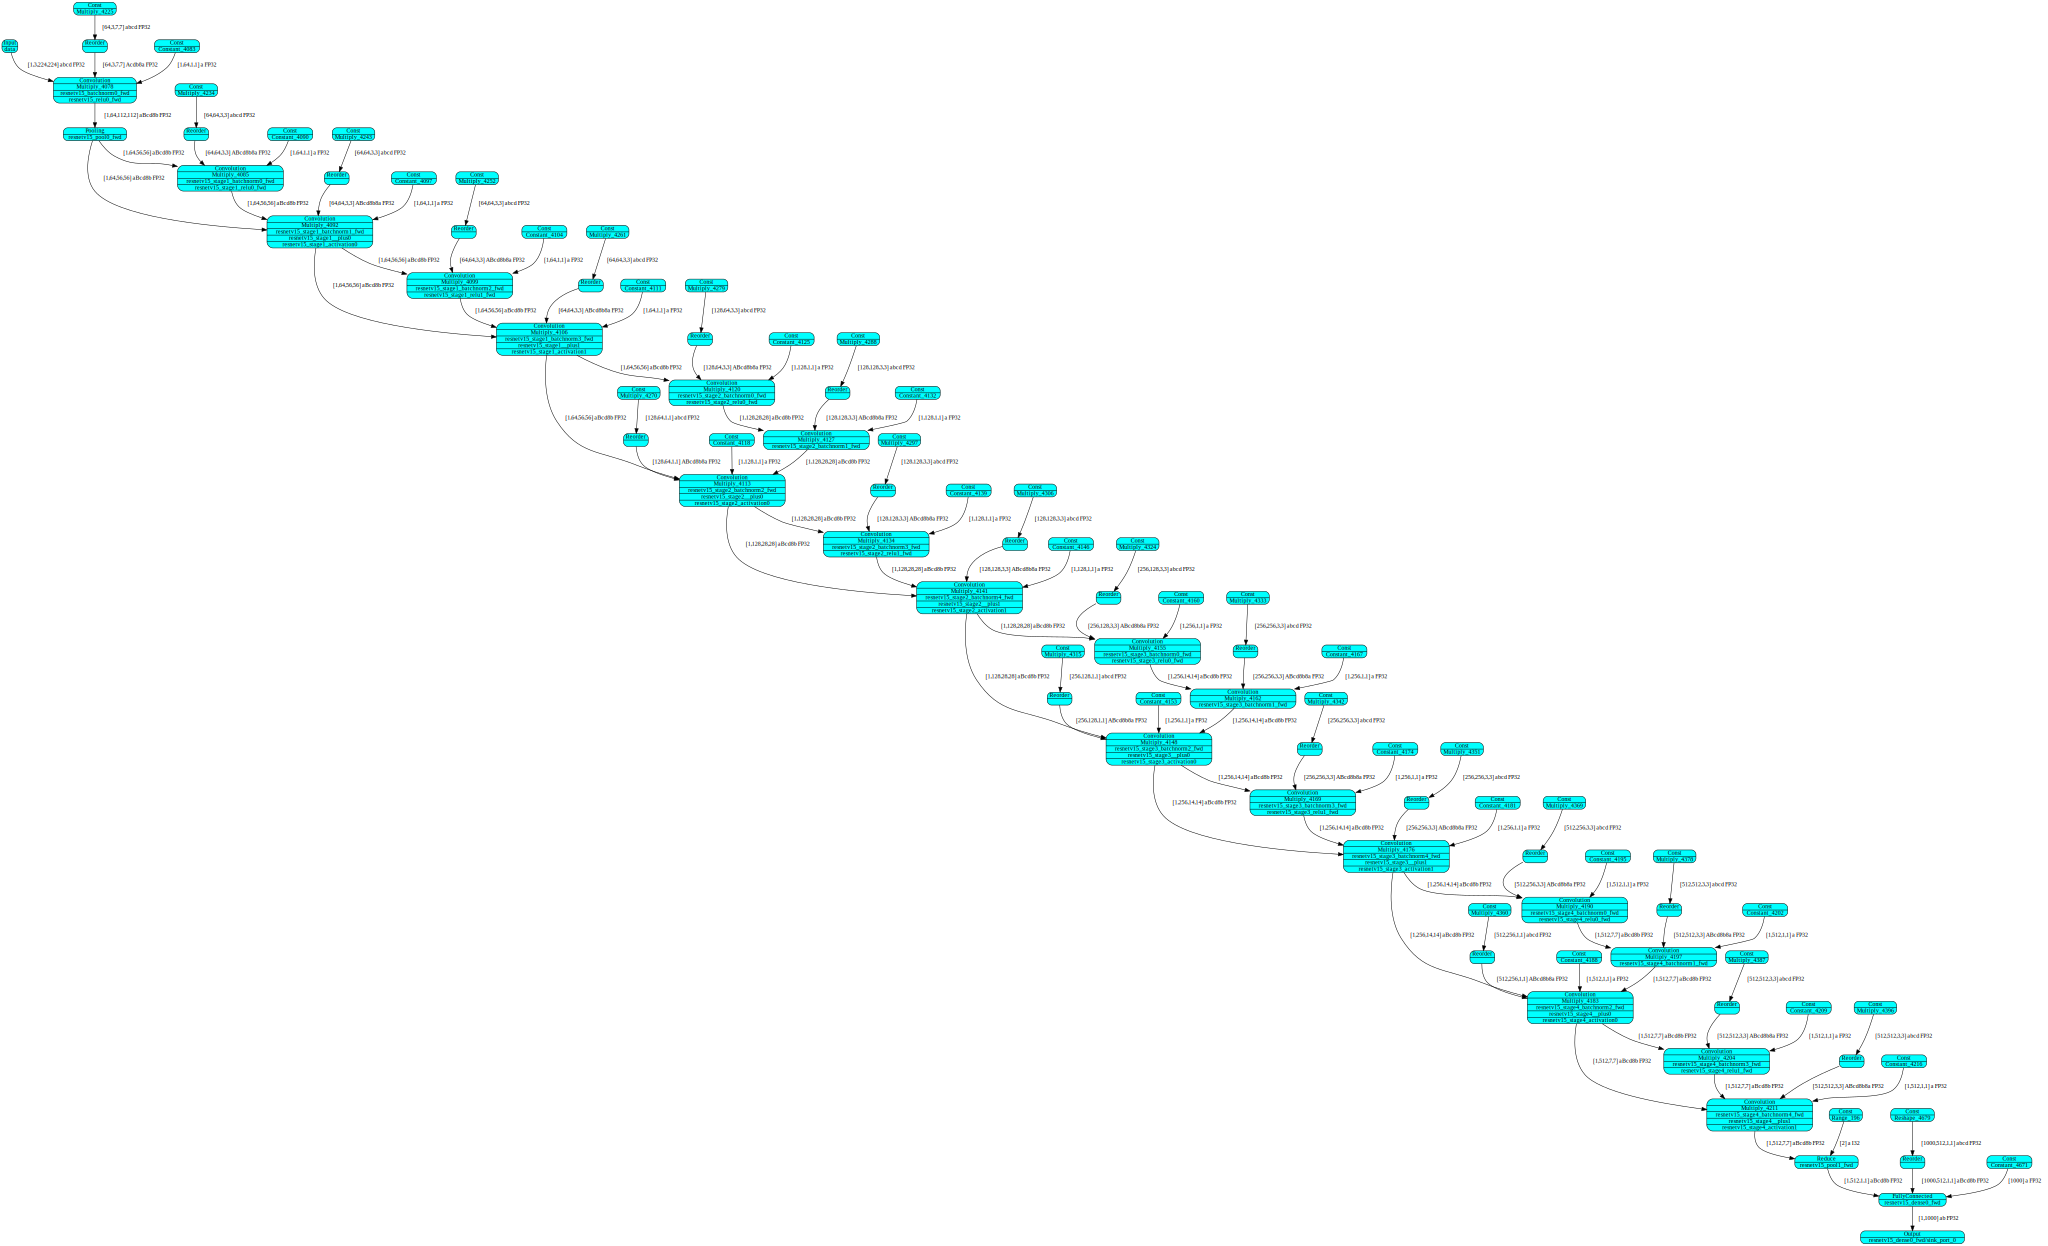

In [2]:
device = 'CPU'
# enable PERF_COUNT
core.set_property(device, {"PERF_COUNT": "YES"})
compiled_model = core.compile_model(model, device)

for k, input in enumerate(compiled_model.inputs):
    print("inputs[{}]: {}".format(k,input))
for k, output in enumerate(compiled_model.outputs):
    print("outputs[{}]: {}".format(k,output))

rt_model = compiled_model.get_runtime_model()
ovhelper.visualize_model(rt_model)

We saw a lot of optimization is going around here, including:
 - mapping from ngraph OP to CPU plugin OP
 - fusion of adjacent layers

And all these are done automatically, w/o human intervention, this is the best situation. not we can run inference with it

num_request=1 time_used=3.036939859390259 sec
num_request=8 time_used=2.8684349060058594 sec


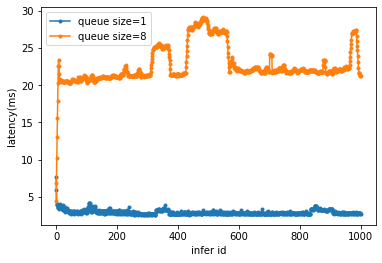

In [14]:
def test_infer_queue(num_request, num_infer):
    infer_queue = ov.AsyncInferQueue(compiled_model, num_request)

    inode = compiled_model.input(0)

    latency_list = []
    def callback(request, userdata):
        id = userdata
        latency_list.append(request.latency)

        #print("infer for id={}".format(id))
        #for k, tensor in enumerate(request.outputs):
        #    print("  output[{}]:  {} {}".format(k, tensor, tensor.data))

    infer_queue.set_callback(callback)

    for i in range(num_infer):
        input = ov.Tensor(inode.get_element_type(), inode.get_shape())
        input.data[:] = i
        infer_queue.start_async({0: input}, userdata=i)

    infer_queue.wait_all()
    return latency_list

import matplotlib.pyplot as plt

for num_request in [1,8]:
    t0 = time.time()
    latency_list = test_infer_queue(num_request, 100)
    print("num_request={} time_used={} sec".format(num_request, time.time() - t0))
    plt.plot(latency_list, '.-', label="queue size={}".format(num_request))
plt.ylabel("latency(ms)")
plt.xlabel("infer id")
plt.legend()
plt.show()